In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Traffic matrices and server popularity distributions

In [2]:
def generate_traffic_matrix(sending, receiving):
    # normalize vectors
    sending = sending / np.linalg.norm(sending)
    receiving = receiving / np.linalg.norm(receiving)

    # sending and receiving are vectors of length n, reshape them to be nx1 and 1xn
    sending = np.reshape(sending, (len(sending), 1))
    receiving = np.reshape(receiving, (1, len(receiving)))
    
    # multiply the two vectors to get an nxn matrix 
    matrix = sending @ receiving
    np.fill_diagonal(matrix, 0)
    
    return matrix / np.sum(matrix)

Different distributions for server popularity

In [3]:
def generate_unif(n):
    # generate a uniform vector of length n
    return np.ones(n) / n

In [4]:
def generate_random(n):
    # generate a random vector of length n
    popularities = np.random.rand(n)
    return popularities / np.linalg.norm(popularities)

In [5]:
def generate_gaussian(n, std=0.1):
    # generate a uniform vector of length n, with some Gaussian noise added. default std is 0.1
    popularities = np.random.rand(n) + np.random.normal(0, std, n)
    return popularities / np.linalg.norm(popularities)

In [6]:
# Generate popularities according to Pareto dist

def generate_zipf(n, repeat=1):
    """Returns nodes' popularities according to Zipf dist
    ARGS:
        n: number of nodes
        repeat: number of nodes with 1/i popularity
        
    OUTPUTS:
        popularities: list of popularity for each node, following an approximate Zipf distribution
    """
    
    popularities = np.array([1/np.ceil(i/repeat) for i in range(1,n+1)]) # repeated Zipf function
    return popularities / np.linalg.norm(popularities) # normalize


# Jellyfish

In [7]:
def create_jellyfish(num_switches, other_switches_per_switch, servers_per_switch):
    # indices 0 to num_switches - 1 are switches
    G = nx.random_regular_graph(d=other_switches_per_switch, n=num_switches)
    
    # indices num_switches to num_switches + num_switches * servers_per_switch - 1 are servers
    for i in range(num_switches):
        for j in range(servers_per_switch):
            server_index = num_switches + i * servers_per_switch + j 
            G.add_node(server_index)
            G.add_edge(i, server_index)
            # servers.append(server_index)
    
    # list of all servers
    servers = range(num_switches, num_switches + num_switches * servers_per_switch)
    
    return G, servers


range(10, 50)


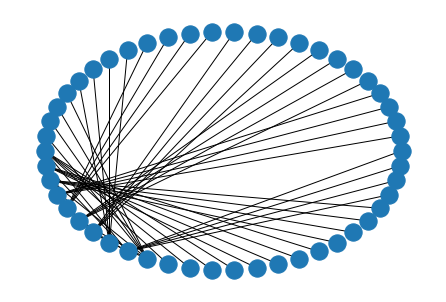

In [11]:
G, servers = create_jellyfish(num_switches=50, other_switches_per_switch=4, servers_per_switch=4)
G, servers = create_jellyfish(num_switches=10, other_switches_per_switch=3, servers_per_switch=4)
print(servers)
# print(nx.shortest_path_length(G, source=30, target=55))
pos = nx.shell_layout(G)
nx.draw(G, pos)
plt.show()

In [14]:
def switch_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return 0.144101239*len(servers) # https://ibmathsresources.com/2022/06/04/finding-the-average-distance-in-a-polygon/
    

def distance_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return np.abs(target-source)
    
nx.shortest_path_length(G, source=12, target=44, weight=distance_weight)


10

In [9]:
def calculate_weighted_path_length(G, servers, edge_weight=None):
    num_servers = len(servers)
    servers = np.random.permutation(servers) # randomly permute servers

    shortest_path_lengths = np.zeros((num_servers, num_servers))
    for i in range(num_servers):
        for j in range(num_servers):
            shortest_path_lengths[i, j] = nx.shortest_path_length(G, source=servers[i], target=servers[j], weight=edge_weight)

    unif_traffic_matrix = generate_traffic_matrix(generate_unif(num_servers), generate_unif(num_servers)) 
    print("Uniform traffic", np.sum(np.multiply(shortest_path_lengths, unif_traffic_matrix)))
    rand_dist = generate_random(num_servers)
    random_traffic_matrix = generate_traffic_matrix(rand_dist, rand_dist)
    print("Random traffic", np.sum(np.multiply(shortest_path_lengths, random_traffic_matrix)))
    gaus_dist = generate_gaussian(num_servers, std=0.25)
    gaussian_traffic_matrix = generate_traffic_matrix(gaus_dist, gaus_dist)
    print("Gaussian traffic", np.sum(np.multiply(shortest_path_lengths, gaussian_traffic_matrix)))
    zipf_traffic_matrix = generate_traffic_matrix(generate_zipf(num_servers, repeat=5), generate_zipf(num_servers, repeat=5))
    print("Zipf traffic", np.sum(np.multiply(shortest_path_lengths, zipf_traffic_matrix)))

    

In [15]:
calculate_weighted_path_length(G, servers, edge_weight=switch_weight)

Uniform traffic 12.286611522461538
Random traffic 12.274474435759416
Gaussian traffic 12.279451261656764
Zipf traffic 12.25308018006242


In [16]:
calculate_weighted_path_length(G, servers, edge_weight=distance_weight)

Uniform traffic 6.533333333333333
Random traffic 6.52332897615733
Gaussian traffic 6.698039466279408
Zipf traffic 6.300206382849953


In [34]:
for (num_switches, others) in [(10, 3), (30, 5), (50, 7), (70, 12), (200, 20)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=others, servers_per_switch=4)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    print("\n")

Uniform traffic 3.7435897435897436
Random traffic 3.736088389866515
Gaussian traffic 3.7303270548764575
Zipf traffic 3.7607241428226965


Uniform traffic 4.119887955182074
Random traffic 4.128870290016478
Gaussian traffic 4.119172029985917
Zipf traffic 4.081089642299602


Uniform traffic 4.15638190954774
Random traffic 4.154977396010942
Gaussian traffic 4.162252433869407
Zipf traffic 4.143677394220199


Uniform traffic 3.885919098822324
Random traffic 3.8833175455168965
Gaussian traffic 3.8913892593845523
Zipf traffic 3.8752943413720704


Uniform traffic 3.9987484355444316
Random traffic 3.999083874371127
Gaussian traffic 3.9971711186123913
Zipf traffic 3.983994091916054




In [35]:
for (num_switches, others) in [(50, 7), (100, 15), (200, 20), (400, 30), (800, 40)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=others, servers_per_switch=4)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    print("\n")

Uniform traffic 4.1306532663316595
Random traffic 4.121035252449204
Gaussian traffic 4.119315860442639
Zipf traffic 4.111812290356462


Uniform traffic 3.900551378446113
Random traffic 3.8992763828847368
Gaussian traffic 3.8997496136141443
Zipf traffic 3.9043920250116697


Uniform traffic 3.9964455569461825
Random traffic 3.9958785953911917
Gaussian traffic 3.995924168678199
Zipf traffic 4.003750396309134


Uniform traffic 4.006929330831781
Random traffic 4.007387257250965
Gaussian traffic 4.006890104609228
Zipf traffic 4.0066244401137725


Uniform traffic 4.069399812441418
Random traffic 4.069694277596561
Gaussian traffic 4.069980463925756
Zipf traffic 4.062904247909642




# Fat-tree

In [18]:
def create_fattree(ports_per_switch):
    core_switches = ports_per_switch ** 2 // 2
    agg_switches = ports_per_switch ** 2 // 2
    edge_switches = ports_per_switch ** 2 // 2
    servers = ports_per_switch ** 3 // 4
    print("switches", core_switches + agg_switches + edge_switches, "servers", servers)

    G = nx.Graph()
    G.add_nodes_from(range(core_switches + agg_switches + edge_switches + servers))

    # connect core switches to agg switches
    for i in range(core_switches): # i is core switch index
        for j in range(agg_switches): # j is agg switch index
            if j%2 == 0 and i < ports_per_switch//2:
                G.add_edge(i, core_switches + j)
            elif j%2 == 1 and i >= ports_per_switch//2:
                G.add_edge(i, core_switches + j)
    
    # connect agg switches to edge switches
    for i in range(agg_switches): # i is agg switch index
        agg_pod = (i) // (ports_per_switch//2)
        for j in range(edge_switches): # j is edge switch index
            if (j) // (ports_per_switch//2) == agg_pod:
                G.add_edge(core_switches + i, core_switches + agg_switches + j)
    
    # connect edge switches to servers
    for i in range(edge_switches): # i is edge switch index
        for j in range(servers):
            if (j) // (ports_per_switch//2)**2 == i:
                G.add_edge(core_switches + agg_switches + i, core_switches + agg_switches + edge_switches + j)

    return G, range(core_switches + agg_switches + edge_switches, core_switches + agg_switches + edge_switches + servers)

    

In [29]:
def create_fat_tree_v2(ports_per_switch):
    k = ports_per_switch
    core_switches = (k // 2) * (k // 2)
    agg_switches = (k // 2) * k
    edge_switches = (k // 2) * k
    servers = k ** 3 // 4
    print(f"Tot switch: {core_switches + agg_switches + edge_switches} Tot server: {servers}")
    
    G = nx.Graph()
    G.add_nodes_from(range(core_switches + agg_switches + edge_switches + servers))
    

    # connect agg to core
    core_idx = 0
    pod_num = 0
    for j in range(core_switches, core_switches + agg_switches):
        for _ in range(k // 2):
            G.add_edge(core_idx, j)
            core_idx += 1
            if (core_idx == core_switches):
                pod_num += 1
                core_idx = 0

    # connect edge to agg
    pod_num = 0
    cur_pod = 0
    for j in range(core_switches + agg_switches, core_switches + agg_switches + edge_switches):
        for i in range(k // 2):
            G.add_edge(j, core_switches + pod_num * (k // 2) + i)
        cur_pod += 1
        if (cur_pod == (k // 2)):
            cur_pod = 0
            pod_num += 1
    
    # connect server to edge
    serv_num = core_switches + agg_switches + edge_switches
    for i in range(core_switches + agg_switches, core_switches + agg_switches + edge_switches):
        for _ in range(k // 2):
            G.add_edge(i, serv_num)
            serv_num += 1
    return G, range(core_switches + agg_switches + edge_switches, core_switches + agg_switches + edge_switches + servers)

switches 6 servers 2
switches 24 servers 16
switches 54 servers 54
Tot switch: 80 Tot server: 128
range(80, 208)
4


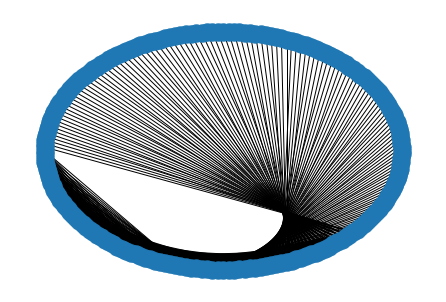

In [30]:
G2, servers2 = create_fattree(ports_per_switch=2)
G2, servers2 = create_fattree(ports_per_switch=4)
G2, servers2 = create_fattree(ports_per_switch=6)
G2, servers2 = create_fat_tree_v2(ports_per_switch=8)
print(servers2)
print(nx.shortest_path_length(G2, source=20, target=35))
pos = nx.shell_layout(G2)
nx.draw(G2, pos)
plt.show()

In [20]:
calculate_weighted_path_length(G2, servers2, edge_weight=None)

Uniform traffic 4.771653543307087
Random traffic 4.776050504407983
Gaussian traffic 4.77350578284596
Zipf traffic 4.781042440539365


In [21]:
def core_weight(source, target, edge_attr):
    if source in core_switches or target in core_switches:
        return int(np.sqrt(2*core_switches)) + 1
    else:
        return 1

In [31]:
for k in [4, 6, 8]:
    # G2, servers2 = create_fattree(ports_per_switch=k)
    G2, servers2 = create_fat_tree_v2(ports_per_switch=k)
    core_switches = k ** 2 // 2
    calculate_weighted_path_length(G2, servers2, edge_weight=core_switches)
    print("\n")


Tot switch: 20 Tot server: 16
Uniform traffic 5.466666666666667
Random traffic 5.420280308777691
Gaussian traffic 5.479115828070513
Zipf traffic 5.493378607809847


Tot switch: 45 Tot server: 54
Uniform traffic 5.622641509433965
Random traffic 5.624756428898969
Gaussian traffic 5.625201725053719
Zipf traffic 5.607822840475763


Tot switch: 80 Tot server: 128
Uniform traffic 5.716535433070868
Random traffic 5.722401815253093
Gaussian traffic 5.719052380090139
Zipf traffic 5.7138590307518635




In [24]:
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k//2, servers_per_switch=k//2)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 8.127659574468087
Random traffic 8.129076139418025
Gaussian traffic 8.132372041955218
Zipf traffic 7.93843985541069
Uniform traffic 44.38416016885107
Random traffic 44.04174470674131
Gaussian traffic 44.46389663283438
Zipf traffic 44.9196539973382


Uniform traffic 6.236714975845411
Random traffic 6.273358444382156
Gaussian traffic 6.165283646067687
Zipf traffic 6.175168529685867
Uniform traffic 100.90357212408696
Random traffic 100.14030911368864
Gaussian traffic 101.25724723652351
Zipf traffic 99.1555844395682


Uniform traffic 5.441906005221931
Random traffic 5.4388031873484355
Gaussian traffic 5.439602403798292
Zipf traffic 5.442796450869328
Uniform traffic 192.45744123162396
Random traffic 192.4517244885802
Gaussian traffic 192.32253172685859
Zipf traffic 190.87618330657895




In [25]:
# more switch-switch connections
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.869565217391305
Random traffic 4.86312348554205
Gaussian traffic 4.74762638730558
Zipf traffic 4.820161789242797
Uniform traffic 11.924189677217392
Random traffic 12.078485817213501
Gaussian traffic 11.860837498559555
Zipf traffic 12.086459979705701


Uniform traffic 5.0633437175493246
Random traffic 5.077348953184341
Gaussian traffic 5.073220560870392
Zipf traffic 5.158696135750528
Uniform traffic 49.67461551962616
Random traffic 49.7910976053285
Gaussian traffic 49.43089942530435
Zipf traffic 50.31267629340553


Uniform traffic 4.702879581151833
Random traffic 4.705306851505206
Gaussian traffic 4.697387640171901
Zipf traffic 4.72166993363248
Uniform traffic 76.78175293026177
Random traffic 76.80966381255783
Gaussian traffic 76.71297015992162
Zipf traffic 76.31599070346421




In [26]:
# match number of servers
for (num_servers, k) in [(16, 4), (54, 6), (128, 8)]:
    num_switches = num_servers // (k // 3)
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.425000000000001
Random traffic 4.46107997583468
Gaussian traffic 4.490584249998069
Zipf traffic 4.3758913412563665
Uniform traffic 7.5911280732
Random traffic 7.656644328662639
Gaussian traffic 7.375894213754751
Zipf traffic 7.531138898662137


Uniform traffic 4.342417889587702
Random traffic 4.34049888490547
Gaussian traffic 4.328761407618142
Zipf traffic 4.347101905076215
Uniform traffic 20.227447287849056
Random traffic 20.269631718430077
Gaussian traffic 19.954614943751576
Zipf traffic 20.230501088096183


Uniform traffic 4.470964566929133
Random traffic 4.477988057322517
Gaussian traffic 4.484457096511969
Zipf traffic 4.480164807145931
Uniform traffic 47.57683911930709
Random traffic 47.72945924183503
Gaussian traffic 47.46874966219906
Zipf traffic 47.842303613307884


